In [98]:
from astropy.io import fits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from tqdm import tqdm

# Load the FITS file
with fits.open(r"c:\Github\M33_Analysis\Tables\m33_vels_stars_inc22B_donedupes.fits") as hdul:
    data = hdul[1].data
    df = pd.DataFrame(data.astype(data.dtype.newbyteorder('=')))

# Remove foreground stars
print(f"Total stars before Foreground removal: {len(df)}")
df = df[df['FG_SEL'] != 1].copy()
print(f"Total stars after Foreground removal: {len(df)}")

# Robustly remove stars with ZQUALITY == 1
if 'ZQUALITY' in df.columns:
    print('ZQUALITY unique values before:', pd.unique(df['ZQUALITY']))
    print('ZQUALITY dtype before:', df['ZQUALITY'].dtype)
    df['ZQUALITY'] = pd.to_numeric(df['ZQUALITY'], errors='coerce')
    before = len(df)
    df = df[df['ZQUALITY'] != 1].copy()
    print('ZQUALITY unique values after:', pd.unique(df['ZQUALITY']))
    print('ZQUALITY dtype after:', df['ZQUALITY'].dtype)
    print(f"Total stars after ZQUALITY==1 removal: {len(df)} (removed {before - len(df)})")
else:
    print("Warning: 'ZQUALITY' column not found in df.")

Total stars before Foreground removal: 5775
Total stars after Foreground removal: 5256
ZQUALITY unique values before: [1 3 4]
ZQUALITY dtype before: int16
ZQUALITY unique values after: [3 4]
ZQUALITY dtype after: int16
Total stars after ZQUALITY==1 removal: 4651 (removed 605)


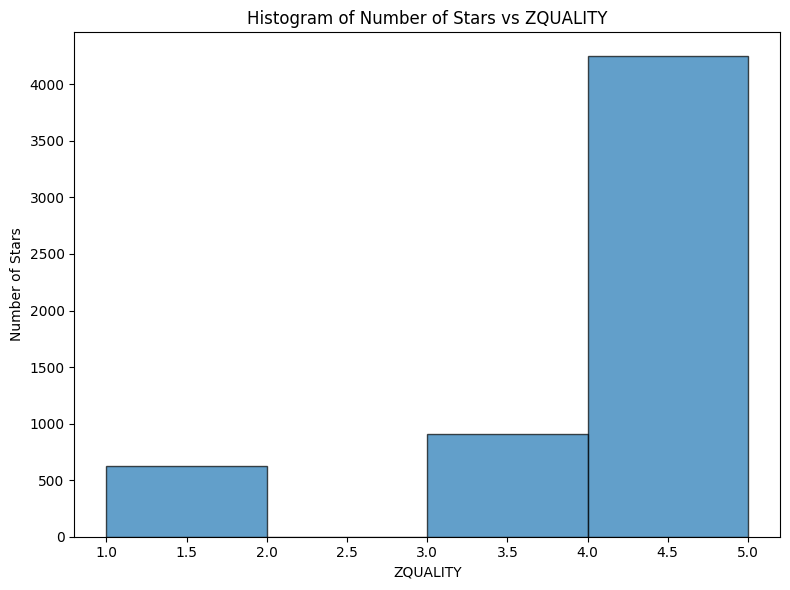

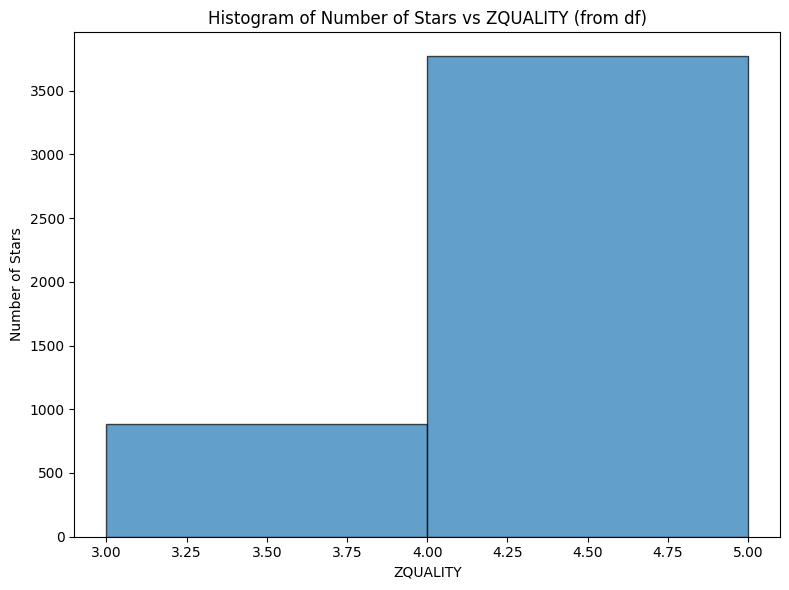

In [99]:
import matplotlib.pyplot as plt
from astropy.table import Table
import os

# Path to the FITS file (use absolute path for reliability)
fits_file = r'c:\Github\M33_Analysis\Tables\m33_vels_stars_inc22B_donedupes.fits'

table = Table.read(fits_file)

# Check if ZQUALITY column exists
if 'ZQUALITY' not in table.colnames:
    raise ValueError('ZQUALITY column not found in FITS file.')

zquality = table['ZQUALITY']

plt.figure(figsize=(8,6))
plt.hist(zquality, bins=range(int(zquality.min()), int(zquality.max())+2), edgecolor='black', alpha=0.7)
plt.xlabel('ZQUALITY')
plt.ylabel('Number of Stars')
plt.title('Histogram of Number of Stars vs ZQUALITY')
plt.tight_layout()
plt.show()

# Plot ZQUALITY distribution from the DataFrame df
if 'ZQUALITY' not in df.columns:
    raise ValueError('ZQUALITY column not found in DataFrame.')

zquality = df['ZQUALITY']

plt.figure(figsize=(8,6))
plt.hist(zquality, bins=range(int(zquality.min()), int(zquality.max())+2), edgecolor='black', alpha=0.7)
plt.xlabel('ZQUALITY')
plt.ylabel('Number of Stars')
plt.title('Histogram of Number of Stars vs ZQUALITY (from df)')
plt.tight_layout()
plt.show()


In [100]:
from collections import Counter

# Define the SEL flags to check
sel_flags = ['RGB_SEL', 'AGB_SEL', 'CBN_SEL', 'YMS_SEL', 'WCN_SEL', 'RHB_SEL', 'OHB_SEL' , 'FG_SEL']

def get_active_flags(row):
    return tuple(sorted([flag for flag in sel_flags if row[flag] == 1]))


df['sel_combo'] = df.apply(get_active_flags, axis=1)

# Count frequency of each unique flag combination
combo_counts = Counter(df['sel_combo'])

# Display results
print("Number of stars for each SEL flag combination:")
for combo, count in combo_counts.items():
    label = ', '.join(combo) if combo else 'None'
    print(f"{label}: {count}")

Number of stars for each SEL flag combination:
RGB_SEL: 2189
AGB_SEL: 579
OHB_SEL: 390
YMS_SEL: 186
OHB_SEL, WCN_SEL: 38
RHB_SEL: 577
AGB_SEL, CBN_SEL: 144
RHB_SEL, WCN_SEL: 390
CBN_SEL, RHB_SEL: 10
RGB_SEL, WCN_SEL: 53
AGB_SEL, WCN_SEL: 51
CBN_SEL, RGB_SEL: 21
WCN_SEL, YMS_SEL: 3
None: 19
WCN_SEL: 1


In [101]:

df['age_group'] = 'unclassified'


df.loc[df['WCN_SEL'] == 1, 'age_group'] = 'young'
df.loc[df['CBN_SEL'] == 1, 'age_group'] = 'int'


df.loc[
    (df['age_group'] == 'unclassified') & (df['RGB_SEL'] == 1),
    'age_group'
] = 'old'


df.loc[
    (df['age_group'] == 'unclassified') & (df['AGB_SEL'] == 1),
    'age_group'
] = 'int'

df.loc[
    (df['age_group'] == 'unclassified') & 
    ((df['YMS_SEL'] == 1)),
    'age_group'
] = 'young'


print(df['age_group'].value_counts())

age_group
old             2189
unclassified     986
int              754
young            722
Name: count, dtype: int64


Number of stars per age group:
  old: g-i panel = 1005, F475W0-F814W0 panel = 997, F606W0-F814W0 panel = 263
  int: g-i panel = 250, F475W0-F814W0 panel = 427, F606W0-F814W0 panel = 81
  young: g-i panel = 300, F475W0-F814W0 panel = 582, F606W0-F814W0 panel = 39


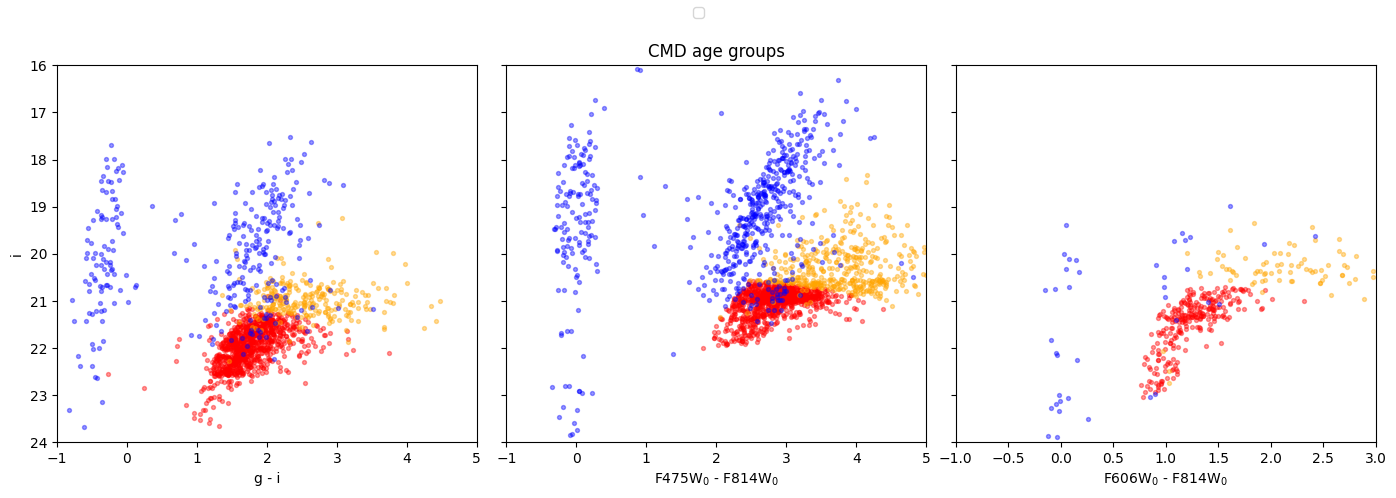

In [102]:
# Filter data by availability of magnitudes  172 284 63
df1 = df[(df['g'].notnull()) & (df['i'].notnull())]
df2 = df[(df['F475W0_ACS'].notnull()) & (df['F814W0_ACS'].notnull())]
df3 = df[(df['F606W0_ACS'].notnull()) & (df['F814W0_ACS'].notnull())]

# Set color and label mappings
colors = {'young': 'blue', 'int': 'orange', 'old': 'red'}
labels = {'young': 'young', 'int': 'intermediate', 'old': 'old'}

# Print number of stars per age group for each CMD panel
print('Number of stars per age group:')
for group in ['old', 'int', 'young']:
    n1 = len(df1[df1['age_group'] == group])
    n2 = len(df2[df2['age_group'] == group])
    n3 = len(df3[df3['age_group'] == group])
    print(f"  {group}: g-i panel = {n1}, F475W0-F814W0 panel = {n2}, F606W0-F814W0 panel = {n3}")

# Plot CMDs
fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=True)

# Panel 1: g - i vs i
for group in ['old', 'int', 'young']:
    subset = df1[df1['age_group'] == group]
    axes[0].scatter(subset['g'] - subset['i'], subset['i'], color=colors[group], s=8, alpha=0.4)
axes[0].invert_yaxis()
axes[0].set_xlim(-1, 5)
axes[0].set_ylim(24, 16)
axes[0].set_xlabel('g - i')
axes[0].set_ylabel('i')

# Panel 2: F475W0 - F814W0
for group in ['old', 'int', 'young']:
    subset = df2[df2['age_group'] == group]
    axes[1].scatter(subset['F475W0_ACS'] - subset['F814W0_ACS'], subset['F814W0_ACS'], color=colors[group], s=8, alpha=0.4)
axes[1].invert_yaxis()
axes[1].set_xlim(-1, 5)
axes[1].set_ylim(24, 16)
axes[1].set_xlabel('F475W$_0$ - F814W$_0$')
axes[1].set_title('CMD age groups')

# Panel 3: F606W0 - F814W0
for group in ['old', 'int', 'young']:
    subset = df3[df3['age_group'] == group]
    axes[2].scatter(subset['F606W0_ACS'] - subset['F814W0_ACS'], subset['F814W0_ACS'], color=colors[group], s=8, alpha=0.4)
axes[2].invert_yaxis()
axes[2].set_xlim(-1, 3)
axes[2].set_ylim(24, 16)
axes[2].set_xlabel('F606W$_0$ - F814W$_0$')

# Add unified legend
fig.legend(*axes[0].get_legend_handles_labels(), loc='upper center', ncol=3)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

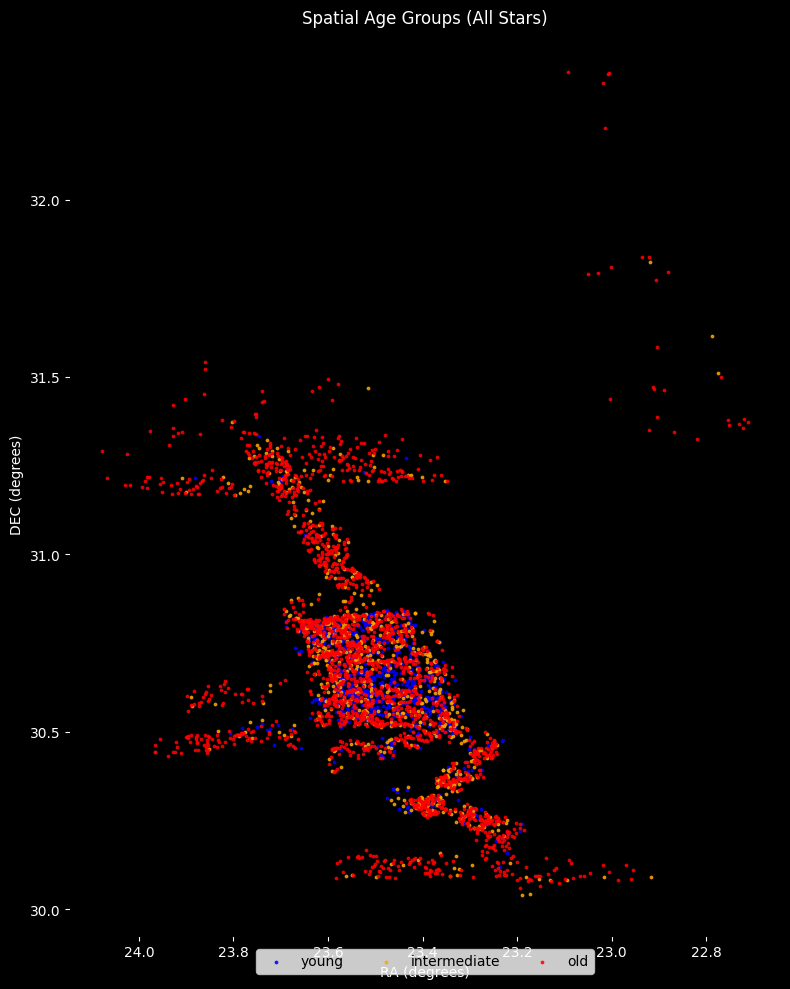

In [103]:
plt.figure(figsize=(8, 10), facecolor='black')
ax = plt.gca()
ax.set_facecolor('black')

for group in ['young', 'int', 'old']:
    subset = df[df['age_group'] == group]
    plt.scatter(subset['RA_DEG'], subset['DEC_DEG'], color=colors[group], s=3, label=labels[group], alpha=0.8)

plt.xlabel("RA (degrees)", color='white')
plt.ylabel("DEC (degrees)", color='white')
plt.tick_params(colors='white')
plt.gca().invert_xaxis()
plt.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))
plt.title("Spatial Age Groups (All Stars)", color='white')
plt.tight_layout()
plt.show()

In [104]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord

# 1. Filter out any null positions
df = df[df['RA_DEG'].notnull() & df['DEC_DEG'].notnull()].copy()

# 2. Build SkyCoord objects
center = SkyCoord(ra=23.4621*u.deg, dec=30.6602*u.deg)  # M33 center
stars  = SkyCoord(ra=df['RA_DEG'].values*u.deg,
                  dec=df['DEC_DEG'].values*u.deg)

# 3. Compute sky-plane offsets in arcmin
offs = stars.transform_to(center.skyoffset_frame())
xi_arcmin  = offs.lon.degree * 60.0   
eta_arcmin = offs.lat.degree * 60.0   

# 4. Galaxy geometry (you can adjust these to your preferred values)
PA_deg  = 22    # position angle of M33’s major axis (deg east of north)
inc_deg = 52    # inclination of M33’s disk (deg)
PA  = np.deg2rad(PA_deg)
inc = np.deg2rad(inc_deg)

alpha = eta_arcmin * np.cos(PA) + xi_arcmin * np.sin(PA)   
beta  = -eta_arcmin * np.sin(PA) + xi_arcmin * np.cos(PA)  

# 6. “Un-tilt” the minor-axis coordinate
beta_prime = beta / np.cos(inc)

r_deproj_arcmin = np.sqrt(alpha**2 + beta_prime**2)

scale = (np.pi/180/60) * 794
df['r_deproj_arcmin'] = r_deproj_arcmin
df['r_deproj_kpc']    = r_deproj_arcmin * scale



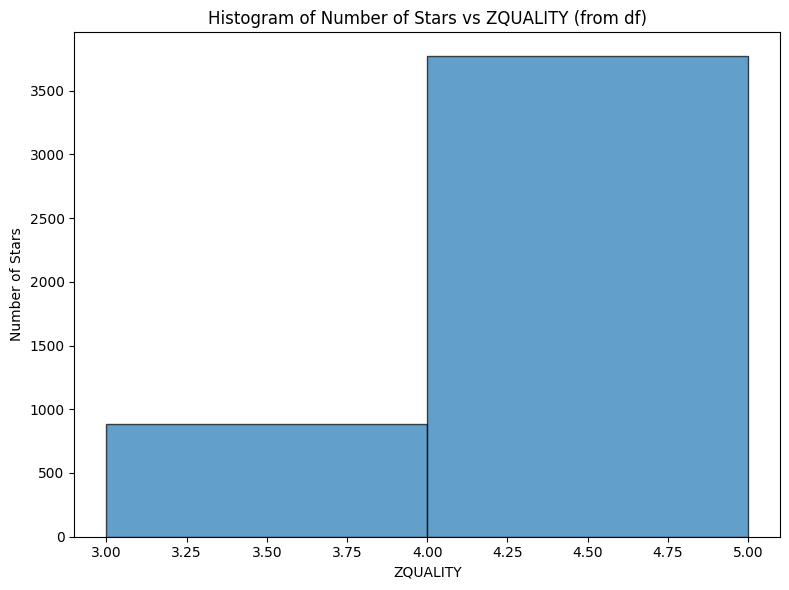

In [105]:
zquality = df['ZQUALITY']

plt.figure(figsize=(8,6))
plt.hist(zquality, bins=range(int(zquality.min()), int(zquality.max())+2), edgecolor='black', alpha=0.7)
plt.xlabel('ZQUALITY')
plt.ylabel('Number of Stars')
plt.title('Histogram of Number of Stars vs ZQUALITY (from df)')
plt.tight_layout()
plt.show()

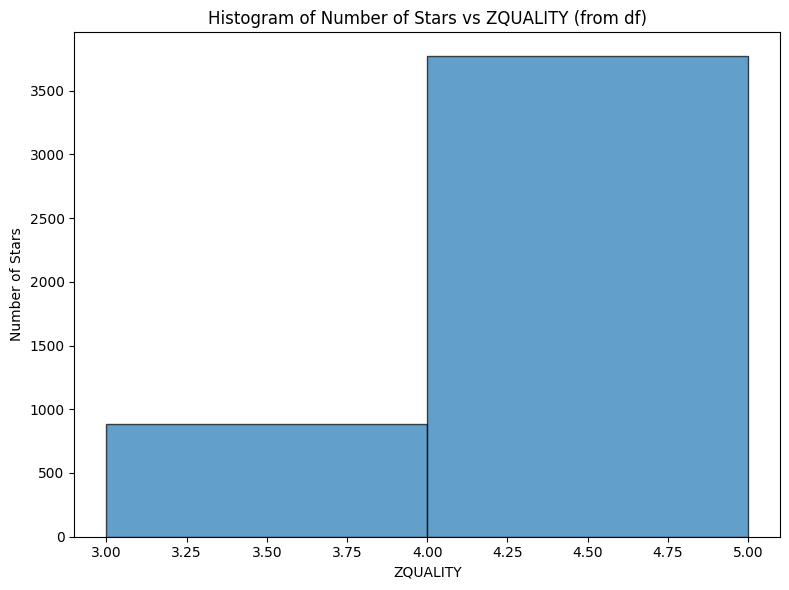

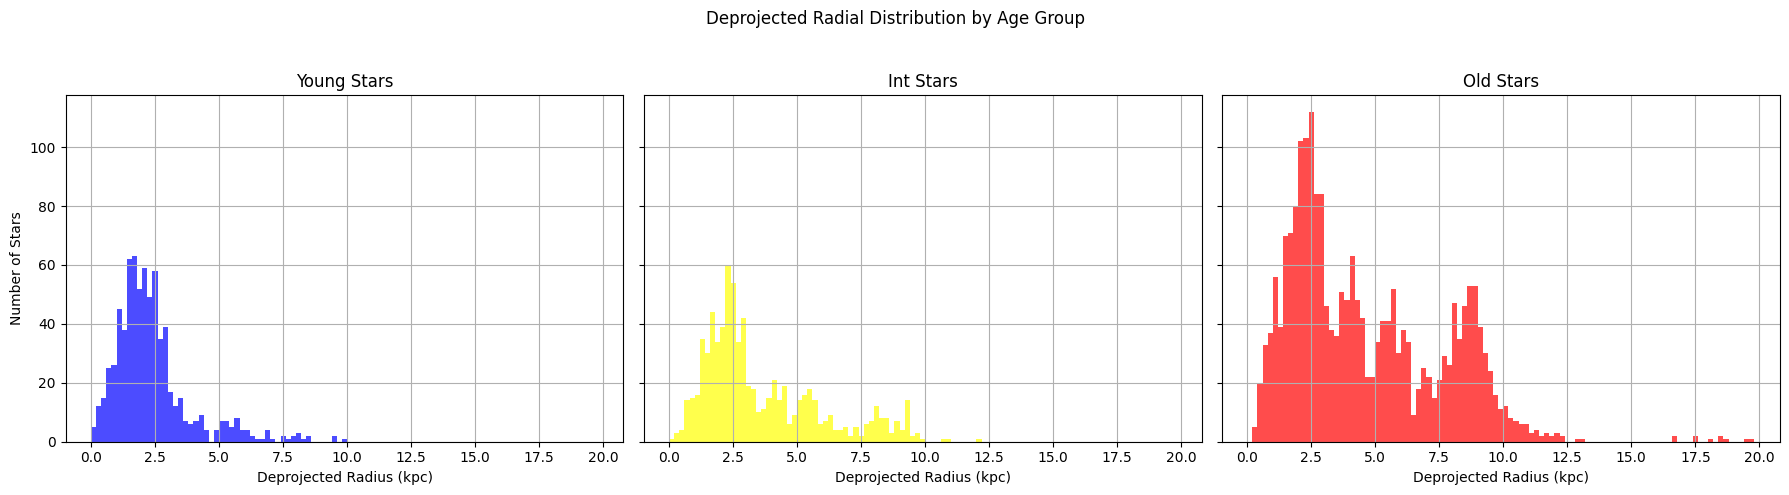

In [106]:
import numpy as np
import matplotlib.pyplot as plt

# === Deprojected radial histogram by age ===
bins = np.arange(0, 20, 0.2)
age_groups = ['young', 'int', 'old']
colors = {'young': 'blue', 'int': 'yellow', 'old': 'red'}

plt.figure(figsize=(8,6))
plt.hist(zquality, bins=range(int(zquality.min()), int(zquality.max())+2), edgecolor='black', alpha=0.7)
plt.xlabel('ZQUALITY')
plt.ylabel('Number of Stars')
plt.title('Histogram of Number of Stars vs ZQUALITY (from df)')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
zquality = df['ZQUALITY']



for ax, group in zip(axes, age_groups):
    subset = df[df['age_group'] == group]
    ax.hist(
        subset['r_deproj_kpc'],
        bins=bins,
        histtype='stepfilled',
        color=colors[group],
        alpha=0.7
    )
    ax.set_title(f'{group.capitalize()} Stars')
    ax.set_xlabel('Deprojected Radius (kpc)')
    if ax is axes[0]:
        ax.set_ylabel('Number of Stars')
    ax.grid(True)

plt.suptitle('Deprojected Radial Distribution by Age Group')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
from astropy.coordinates import SkyCoord, search_around_sky
import astropy.units as u
import pandas as pd
from tqdm import tqdm

# === Split by age group ===
young_df = df[df['age_group'] == 'young'].copy()
int_df   = df[df['age_group'] == 'int'].copy()
old_df   = df[df['age_group'] == 'old'].copy()

# Build SkyCoord objects
young_coords = SkyCoord(ra=young_df['RA_DEG'].values * u.deg, dec=young_df['DEC_DEG'].values * u.deg)
int_coords   = SkyCoord(ra=int_df['RA_DEG'].values * u.deg, dec=int_df['DEC_DEG'].values * u.deg)
old_coords   = SkyCoord(ra=old_df['RA_DEG'].values * u.deg, dec=old_df['DEC_DEG'].values * u.deg)

match_radius = 1.0 * u.arcmin
used_int = set()
used_old = set()
triplets = []

for i in tqdm(range(len(young_df)), desc="Improved matching: young base"):
    y_coord = young_coords[i]
    y_index = young_df.index[i]

    # Match intermediate stars
    _, int_idxs, sep2d_int, _ = search_around_sky(SkyCoord([y_coord]), int_coords, match_radius)
    viable_ints = [(j, s.arcminute) for j, s in zip(int_idxs, sep2d_int) if int_df.iloc[j].name not in used_int]
    if not viable_ints:
        continue
    best_int_idx, _ = min(viable_ints, key=lambda x: x[1])

    # Match old stars
    _, old_idxs, sep2d_old, _ = search_around_sky(SkyCoord([y_coord]), old_coords, match_radius)
    viable_olds = [(j, s.arcminute) for j, s in zip(old_idxs, sep2d_old) if old_df.iloc[j].name not in used_old]
    if not viable_lds:
        continue
    best_old_idx, _ = min(viable_lds, key=lambda x: x[1])

    # Record match
    triplets.append({
        'young_idx': y_index,
        'int_idx': int_df.iloc[best_int_idx].name,
        'old_idx': old_df.iloc[best_old_idx].name
    })

    # Mark as used
    used_int.add(int_df.iloc[best_int_idx].name)
    used_old.add(old_df.iloc[best_old_idx].name)

# Convert to DataFrame
triplets_df = pd.DataFrame(triplets)
print(f"Matched triplets found: {len(triplets_df)}")


Improved matching: young base: 100%|██████████| 2058/2058 [00:17<00:00, 119.66it/s]


Matched triplets found: 717


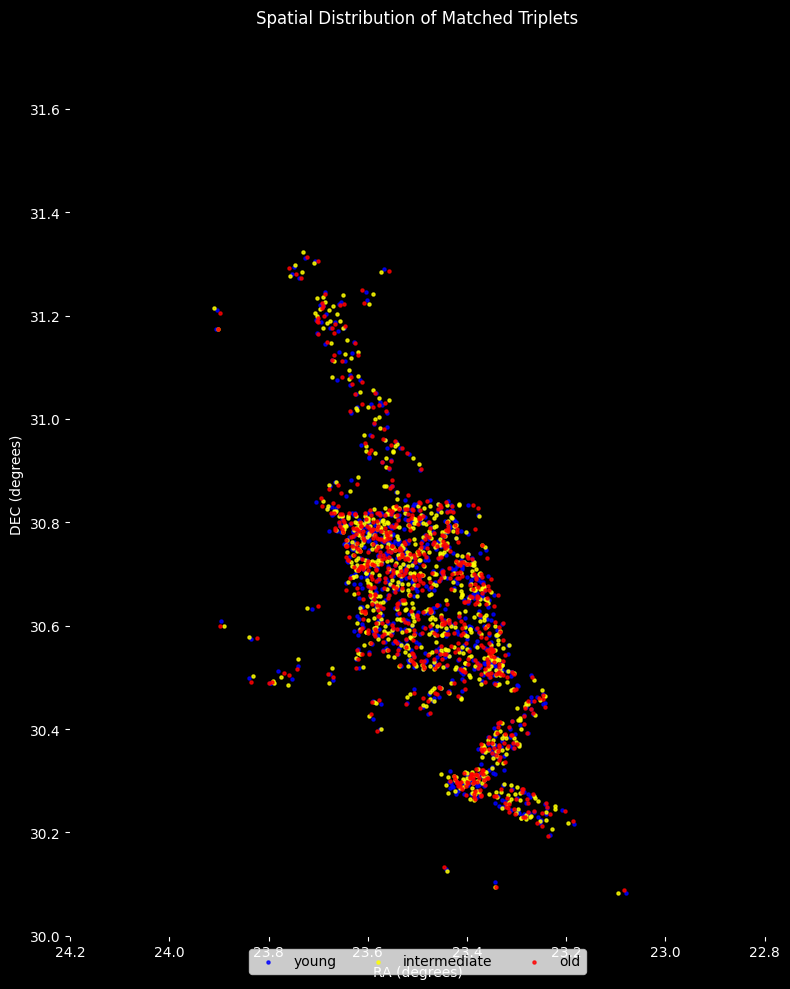

In [16]:
triplet_full_data = pd.concat([
    df.loc[triplets_df['old_idx']].assign(group='old'),
    df.loc[triplets_df['int_idx']].assign(group='int'),
    df.loc[triplets_df['young_idx']].assign(group='young')
]).reset_index(drop=True)


triplet_full_data = triplet_full_data[triplet_full_data['RA_DEG'].notnull() & triplet_full_data['DEC_DEG'].notnull()]

plt.figure(figsize=(8, 10), facecolor='black')
ax = plt.gca()
ax.set_facecolor('black')

for group in ['young', 'int', 'old']:
    subset = triplet_full_data[triplet_full_data['group'] == group]
    plt.scatter(subset['RA_DEG'], subset['DEC_DEG'], color=colors[group], s=5, label=labels[group], alpha=0.8)

plt.xlabel("RA (degrees)", color='white')
plt.ylabel("DEC (degrees)", color='white')
plt.xlim(22.8, 24.2)
plt.ylim(30, 31.75)
plt.tick_params(colors='white')
plt.gca().invert_xaxis()
plt.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))
plt.title("Spatial Distribution of Matched Triplets", color='white')
plt.tight_layout()
plt.show()

In [17]:
import numpy as np
import pandas as pd
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
from scipy.interpolate import interp1d

# === Load disk model ===
diskmodel = Table.read(r'C:\Github\M33_Analysis\SIP Codes\Kam2017_table4.dat', format='ascii',
                       names=['Radius_arcmin', 'Radius_kpc', 'Vrot_kms', 'Delta_Vrot', 'i_deg', 'PA_deg'])


m33coord = SkyCoord(ra='01h33m50.9s', dec='+30d39m36s', unit=(u.hourangle, u.deg))
v_sys = -180.0  # systemic velocity of M33


def major_minor_transform(coords, pa, centercoords=m33coord):
    c_offset = coords.transform_to(centercoords.skyoffset_frame())
    xi, eta = c_offset.lon.degree, c_offset.lat.degree
    alpha = eta * np.cos(pa) + xi * np.sin(pa)
    beta =  - eta * np.sin(pa) + xi * np.cos(pa)
    return alpha, beta

def compute_model_los_velocity(coords):
    Rinit = np.sqrt((coords.ra.degree - m33coord.ra.degree)**2 +
                    (coords.dec.degree - m33coord.dec.degree)**2)
    R_arcmin = Rinit * 60.0

    f_pa = interp1d(diskmodel['Radius_arcmin'], diskmodel['PA_deg'], fill_value="extrapolate")
    f_incl = interp1d(diskmodel['Radius_arcmin'], diskmodel['i_deg'], fill_value="extrapolate")
    f_vrot = interp1d(diskmodel['Radius_arcmin'], diskmodel['Vrot_kms'], fill_value="extrapolate")

    pa = f_pa(R_arcmin) * u.deg
    incl = f_incl(R_arcmin) * u.deg
    vrot = f_vrot(R_arcmin)

    alpha, beta = major_minor_transform(coords, pa)
    phi = np.arctan2(beta / np.cos(incl), alpha)

    vlos = v_sys + vrot * np.sin(incl) * np.cos(phi)
    return vlos

# === Apply model to triplet data ===
triplet_coords = SkyCoord(ra=triplet_full_data['RA_DEG'].values * u.deg,
                          dec=triplet_full_data['DEC_DEG'].values * u.deg)
triplet_full_data['model_vlos'] = compute_model_los_velocity(triplet_coords)

# === Group stars by age ===
youngs = triplet_full_data[triplet_full_data['group'] == 'young'].reset_index(drop=True)
ints   = triplet_full_data[triplet_full_data['group'] == 'int'].reset_index(drop=True)
olds   = triplet_full_data[triplet_full_data['group'] == 'old'].reset_index(drop=True)

# === Create summary DataFrame ===
triplet_grouped = pd.DataFrame({
    'young_RA': youngs['RA_DEG'],
    'young_DEC': youngs['DEC_DEG'],
    'young_vlos': youngs['model_vlos'],
    'young_vcorr_stat': youngs['VCORR_STAT'],

    'int_RA': ints['RA_DEG'],
    'int_DEC': ints['DEC_DEG'],
    'int_vlos': ints['model_vlos'],
    'int_vcorr_stat': ints['VCORR_STAT'],

    'old_RA': olds['RA_DEG'],
    'old_DEC': olds['DEC_DEG'],
    'old_vlos': olds['model_vlos'],
    'old_vcorr_stat': olds['VCORR_STAT']
})

print(triplet_grouped)

      young_RA  young_DEC  young_vlos  young_vcorr_stat     int_RA    int_DEC  \
0    23.589292  30.419000 -140.987354       -118.784611  23.598458  30.425083   
1    23.478125  30.428500 -120.115242       -125.350573  23.482167  30.444306   
2    23.489125  30.441944 -123.569522       -115.278228  23.489375  30.445639   
3    23.469292  30.454611 -119.860387       -117.303919  23.467417  30.453333   
4    23.456917  30.461250 -117.380088        -88.192689  23.473667  30.458500   
..         ...        ...         ...               ...        ...        ...   
712  23.581583  30.711167 -214.527827       -201.734517  23.595542  30.721306   
713  23.605250  30.704056 -210.639777       -203.452249  23.606708  30.717944   
714  23.598542  30.715861 -215.444394       -222.916094  23.595625  30.722639   
715  23.370750  30.659722 -167.776492       -160.981023  23.361667  30.651417   
716  23.520917  30.737667 -231.976990       -233.890492  23.516250  30.740472   

       int_vlos  int_vcorr_

In [39]:
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# STEP 1: Compute velocity offset and remove ZQUALITY == 1
if 'ZQUALITY' in youngs.columns:
    youngs = youngs[youngs['ZQUALITY'] != 1].copy()
else:
    print("Warning: 'ZQUALITY' column not found in youngs DataFrame.")

youngs['delta'] = youngs['VCORR_STAT'] - youngs['model_vlos']
delta = youngs['delta'].dropna().to_numpy().reshape(-1, 1)

# STEP 2: Fit a 2-component Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm.fit(delta)

# STEP 3: Extract model parameters
weights = gmm.weights_          # f_N
means = gmm.means_.flatten()    # μ_N
sigmas = np.sqrt(gmm.covariances_).flatten()  # σ_N

# STEP 4: Compute posterior probabilities
probs = gmm.predict_proba(delta)  # P_{i,N}
hot_idx = np.argmax(sigmas)       # hot component = larger σ
youngs = youngs.loc[~youngs['delta'].isna()].copy()
youngs['prob_hot'] = probs[:, hot_idx]

# Optional: Assign classes (paper doesn't use hard threshold, but you can)
youngs['dyn_class'] = youngs['prob_hot'].apply(lambda p: 'hot' if p > 0.9 else 'cold')

# STEP 5: Plot GMM over data
x_plot = np.linspace(-250, 250, 1000).reshape(-1, 1)
logpdf = gmm.score_samples(x_plot)
pdf = np.exp(logpdf)

plt.figure(figsize=(10, 10))
plt.hist(delta, bins=50, range=(-250, 250), density=True, color='lightgray', edgecolor='black', alpha=0.6, label='Data')
plt.plot(x_plot, pdf, 'r-', lw=2, label='GMM Total')
for i in range(2):
    component = weights[i] * norm.pdf(x_plot.flatten(), means[i], sigmas[i])
    plt.plot(x_plot, component, '--', lw=2, label=f'Component {i+1}')
plt.xlabel("Δv (km/s)")
plt.ylabel("Probability Density")
plt.title("2-Component GMM Fit to Δv")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

In [19]:
print(youngs['dyn_class'].value_counts())

dyn_class
cold    694
hot      23
Name: count, dtype: int64


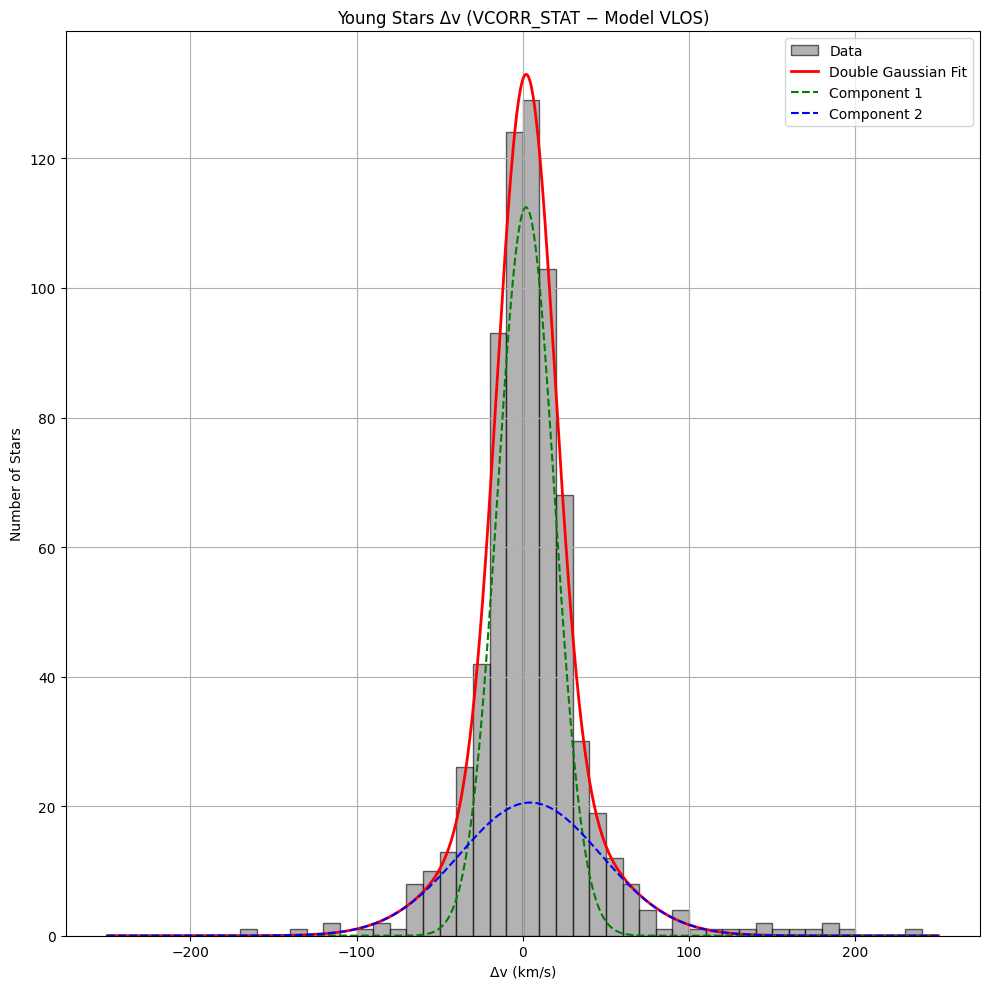

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Compute delta v
youngs['delta'] = youngs['VCORR_STAT'] - youngs['model_vlos']
young_delta_list = youngs['delta'].dropna().to_numpy()

# Histogram setup
xmin, xmax = -250, 250
bins = 50
hist_vals, bin_edges = np.histogram(young_delta_list, bins=bins, range=(xmin, xmax))
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# Define double Gaussian model
def double_gaussian(x, A1, mu1, sigma1, A2, mu2, sigma2):
    gauss1 = A1 * np.exp(-(x - mu1)**2 / (2 * sigma1**2))
    gauss2 = A2 * np.exp(-(x - mu2)**2 / (2 * sigma2**2))
    return gauss1 + gauss2

# Initial guess
p0 = [max(hist_vals), 0, 30, max(hist_vals)/2, -50, 50]

# Fit
params, cov = curve_fit(double_gaussian, bin_centers, hist_vals, p0=p0)
A1, mu1, sigma1, A2, mu2, sigma2 = params

# Generate fit curves
x_fit = np.linspace(xmin, xmax, 1000)
y_fit = double_gaussian(x_fit, *params)
component1 = A1 * np.exp(-(x_fit - mu1)**2 / (2 * sigma1**2))
component2 = A2 * np.exp(-(x_fit - mu2)**2 / (2 * sigma2**2))

# Plot
plt.figure(figsize=(10, 10))
plt.hist(young_delta_list, bins=bins, range=(xmin, xmax), color='gray', edgecolor='black', alpha=0.6, label='Data')
plt.plot(x_fit, y_fit, 'r-', lw=2, label='Double Gaussian Fit')
plt.plot(x_fit, component1, 'g--', label='Component 1')
plt.plot(x_fit, component2, 'b--', label='Component 2')

plt.title("Young Stars Δv (VCORR_STAT − Model VLOS)")
plt.xlabel("Δv (km/s)")
plt.ylabel("Number of Stars")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
from scipy.stats import norm

A1, mu1, sigma1, A2, mu2, sigma2 = params


pdf1 = norm.pdf(youngs['delta'], loc=mu1, scale=sigma1)
pdf2 = norm.pdf(youngs['delta'], loc=mu2, scale=sigma2)


weighted_pdf1 = A1 * pdf1
weighted_pdf2 = A2 * pdf2


total_pdf = weighted_pdf1 + weighted_pdf2


youngs['prob_component2'] = weighted_pdf2 / total_pdf

# Optional: sort or view examples
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', None):
    print(youngs[['delta', 'prob_component2']])

           delta  prob_component2
0      22.202742         0.119210
1      -5.235331         0.072349
2       8.291295         0.072557
3       2.556469         0.068296
4      29.187399         0.179998
5      35.019927         0.267797
6     -66.216779         0.980577
7    -164.971939         1.000000
8     -91.971637         0.999947
9     -31.622544         0.258546
10    -20.010276         0.123733
11    -24.887397         0.164550
12     -1.333456         0.068890
13     -0.865716         0.068672
14      4.088546         0.068820
15    -46.776428         0.669351
16     -2.556144         0.069653
17    -19.125878         0.118093
18      7.559988         0.071652
19     -8.472393         0.077671
20   -133.292969         1.000000
21     -4.291522         0.071234
22      3.316225         0.068502
23      1.016166         0.068201
24    -54.055286         0.856087
25     16.202587         0.090783
26    -54.861167         0.871222
27      8.548755         0.072903
28     -1.7358

In [22]:
def label_dynamical_state(p):
    if p >= 0.95:
        return 'hot'
    else:
        return 'cold'

youngs['dyn_class'] = youngs['prob_component2'].apply(label_dynamical_state)
print(youngs['dyn_class'].value_counts())

dyn_class
cold    673
hot      44
Name: count, dtype: int64


In [77]:
from scipy.stats import norm
from dynesty import NestedSampler
from dynesty.utils import resample_equal
import numpy as np

# STEP 1: Filter usable data
youngs = youngs.dropna(subset=['delta'])
delta = youngs['delta'].values
modelvels = youngs['model_vlos'].values

# STEP 2: Set extras and optflags for genpdf_voffset
inclination = 56 * np.pi / 180
pa = 23 * np.pi / 180
rotation_curve = np.ones_like(delta) * 100  # dummy constant
extras = [inclination, pa, rotation_curve]
optflags = ['T', 'T', 'F']

# STEP 3: Define log-likelihood function
def loglike(parlist, delta, modelvels, extras, optflags):
    try:
        f_rot, sigma_disk, f_halo, mu_halo, sigma_halo = parlist
        if sigma_disk <= 0 or sigma_halo <= 0 or not (0 <= f_halo <= 1):
            return -np.inf
        disk_likelihood = (1 - f_halo) * norm.pdf(delta, loc=0, scale=sigma_disk)
        halo_likelihood = f_halo * norm.pdf(delta, loc=mu_halo, scale=sigma_halo)
        total_likelihood = disk_likelihood + halo_likelihood
        return np.sum(np.log(total_likelihood))
    except:
        return -np.inf

# STEP 4: Define prior transform
def prior_transform(u):
    f_rot = u[0] * 2               # 0–2
    sigma_disk = 5 + 45 * u[1]     # 5–50 km/s
    f_halo = u[2]                  # 0–1
    mu_halo = -20 + 40 * u[3]    # -100 to +100 km/s
    sigma_halo = 10 + 90 * u[4]    # 10–100 km/s
    return [f_rot, sigma_disk, f_halo, mu_halo, sigma_halo]

# STEP 5: Run nested sampling
sampler = NestedSampler(loglike, prior_transform, ndim=5,
                        logl_args=[delta, modelvels, extras, optflags],
                        nlive=500, bound='multi', sample='rwalk')
sampler.run_nested()
results = sampler.results

# STEP 6: Extract best-fit parlist
logwt = results.logwt
logz = results.logz[-1]
weights = np.exp(logwt - logz)
samples_equal = resample_equal(results.samples, weights)
parlist = np.median(samples_equal, axis=0)
print("Best-fit parlist:", parlist)

C:\Users\CoolG\AppData\Local\Temp\ipykernel_36568\486877332.py:27: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(total_likelihood))
0it [00:00, ?it/s]

6825it [01:11, 95.56it/s, +500 | bound: 68 | nc: 1 | ncall: 145036 | eff(%):  5.068 | loglstar:   -inf < -2766.696 <    inf | logz: -2779.680 +/-    nan | dlogz:  0.001 >  0.509]

Best-fit parlist: [1.00019233e+00 2.19821877e+01 9.29188777e-02 1.74205194e+01
 9.94839873e+01]


In [24]:
from scipy.stats import norm
import numpy as np

def genpdf_voffset(xarray, parlist, extras, modelvels, optflags):
    # Unpack parameters
    f_rot, sigma_disk, f_halo, mu_halo, sigma_halo = parlist

    # Unpack extras
    inclination, pa, rotation_curve = extras

    # Disk model: rotating, narrow
    if optflags[0] == 'T':
        veldiskmodel = v_sys + rotation_curve * f_rot * np.cos(pa) * np.sin(inclination)
        vel_disk = np.zeros(len(xarray))
        for v, td in zip(modelvels, veldiskmodel):
            vel_disk += norm.pdf(xarray, v - td, sigma_disk)
        disk_pdf = vel_disk / len(modelvels)
    else:
        disk_pdf = norm.pdf(xarray, 0.0, sigma_disk)

    # Halo model: non-rotating broad
    if optflags[1] == 'T':
        vel_halo = np.zeros(len(xarray))
        for v in modelvels:
            vel_offset_halo = v - mu_halo
            vel_halo += norm.pdf(xarray, vel_offset_halo, sigma_halo)
        halo_pdf = vel_halo / len(modelvels)
    else:
        halo_pdf = np.zeros(len(xarray))

    # Mixture
    total_pdf = (1 - f_halo) * disk_pdf + f_halo * halo_pdf

    # Return all components for plotting or inspection
    return disk_pdf, None, (1 - f_halo) * disk_pdf, halo_pdf, total_pdf, f_halo


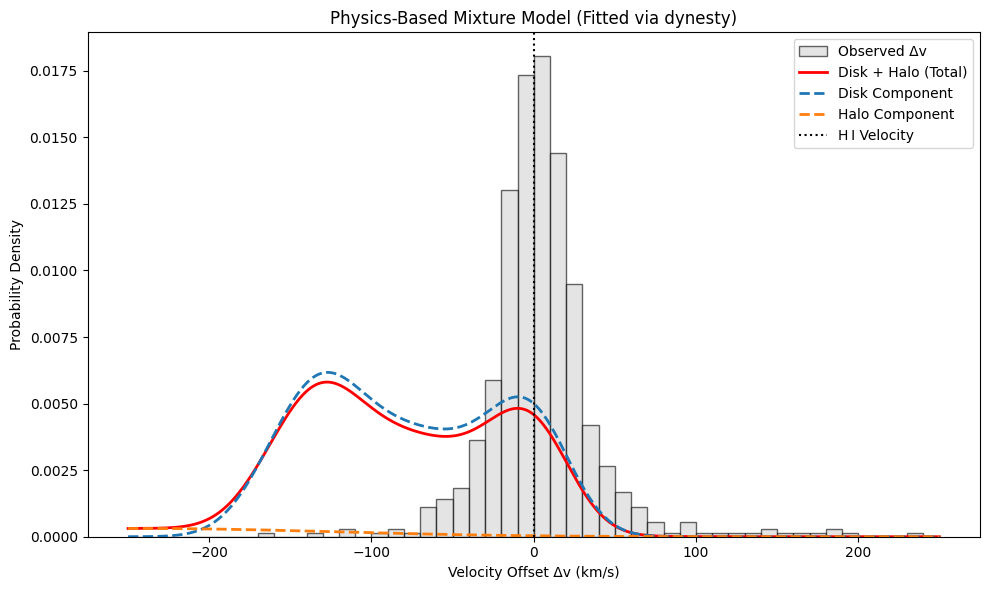

In [25]:
# Generate PDFs for plotting
xarray = np.linspace(-250, 250, 1000)
disk_pdf, _, _, halo_pdf, total_pdf, f_halo = genpdf_voffset(xarray, parlist, extras, modelvels, optflags)

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(delta, bins=50, range=(-250, 250), density=True, color='lightgray', edgecolor='black', alpha=0.6, label='Observed Δv')
plt.plot(xarray, total_pdf, 'r-', lw=2, label='Disk + Halo (Total)')
plt.plot(xarray, disk_pdf, '--', lw=2, label='Disk Component')
plt.plot(xarray, halo_pdf * f_halo, '--', lw=2, label='Halo Component')
plt.axvline(0, color='black', linestyle=':', label='H I Velocity')
plt.xlabel("Velocity Offset Δv (km/s)")
plt.ylabel("Probability Density")
plt.title("Physics-Based Mixture Model (Fitted via dynesty)")
plt.legend()
plt.tight_layout()
plt.show()


[ 0.99777413 21.60831444  0.11097505 17.55258535 99.42248121]


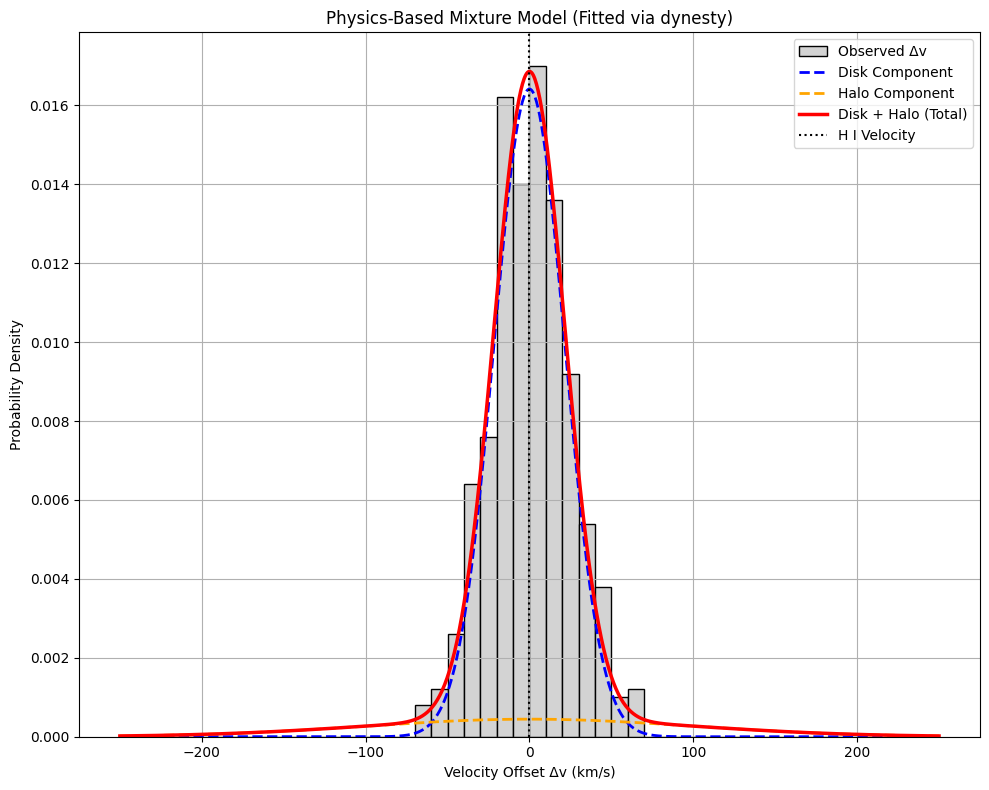

In [73]:
# Re-import after kernel reset
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Best-fit parameters from dynesty (example values)
print(parlist)
# Dummy model velocities and observed data
np.random.seed(42)
modelvels = np.random.normal(0, 20, size=500)
observed_vels = modelvels + np.random.normal(0, 25, size=500)
delta = observed_vels - modelvels

# Extras: [phi (radians), inclination (radians), unit vector for projection]
phi = np.random.uniform(0, 2*np.pi, size=500)
incl = np.radians(np.full_like(phi, 56))  # e.g., 56° inclination
project_unit = np.ones_like(phi)
extras = [phi, incl, project_unit]

# Flags: no tilted disk, include halo
optflags = ['F', 'T']

# Define genpdf_voffset
def genpdf_voffset(xarray, parlist, extras, modelvels, optflags):
    if len(parlist) == 5:
        if optflags[0] == 'T':
            veldiskmodel_td = 0 + extras[2]*parlist[0]*np.cos(extras[1])*np.sin(extras[0])
            vel_disk = np.zeros(len(xarray))
            for v, td in zip(modelvels, veldiskmodel_td):
                vel_disk += norm.pdf(xarray, v - td, parlist[1])
            diskmodel_pdf = vel_disk / len(modelvels)
        else:
            diskmodel_pdf = norm.pdf(xarray, 0., parlist[1])

        multidiskmodel_pdf = (1 - parlist[2]) * diskmodel_pdf
        tdiskmodel_pdf = np.zeros(len(xarray))

        if optflags[1] == 'T':
            vel_halo = np.zeros(len(xarray))
            for v in modelvels:
                veloffset_halo = 0
                vel_halo += norm.pdf(xarray, veloffset_halo, parlist[4])
            halomodel_pdf = vel_halo / len(modelvels)
        else:
            halomodel_pdf = np.zeros(len(xarray))

        diskplushalo_pdf = (1 - parlist[2]) * diskmodel_pdf + parlist[2] * halomodel_pdf
        halofrac = parlist[2]

        return diskmodel_pdf, tdiskmodel_pdf, multidiskmodel_pdf, halomodel_pdf, diskplushalo_pdf, halofrac

# X grid and genpdf
x = np.linspace(-250, 250, 1000)
disk_pdf, _, multi_disk_pdf, halo_pdf, total_pdf, f_halo = genpdf_voffset(
    x, parlist, extras, modelvels, optflags
)

# Plot
plt.figure(figsize=(10, 8))
plt.hist(delta, bins=50, range=(-250, 250), color='lightgray', edgecolor='black',
         density=True, label='Observed Δv')
plt.plot(x, multi_disk_pdf, 'b--', lw=2, label='Disk Component')
plt.plot(x, halo_pdf * f_halo, 'orange', lw=2, linestyle='--', label='Halo Component')
plt.plot(x, total_pdf, 'r-', lw=2.5, label='Disk + Halo (Total)')
plt.axvline(0, color='k', linestyle=':', lw=1.5, label='H I Velocity')
plt.title("Physics-Based Mixture Model (Fitted via dynesty)")
plt.xlabel("Velocity Offset Δv (km/s)")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


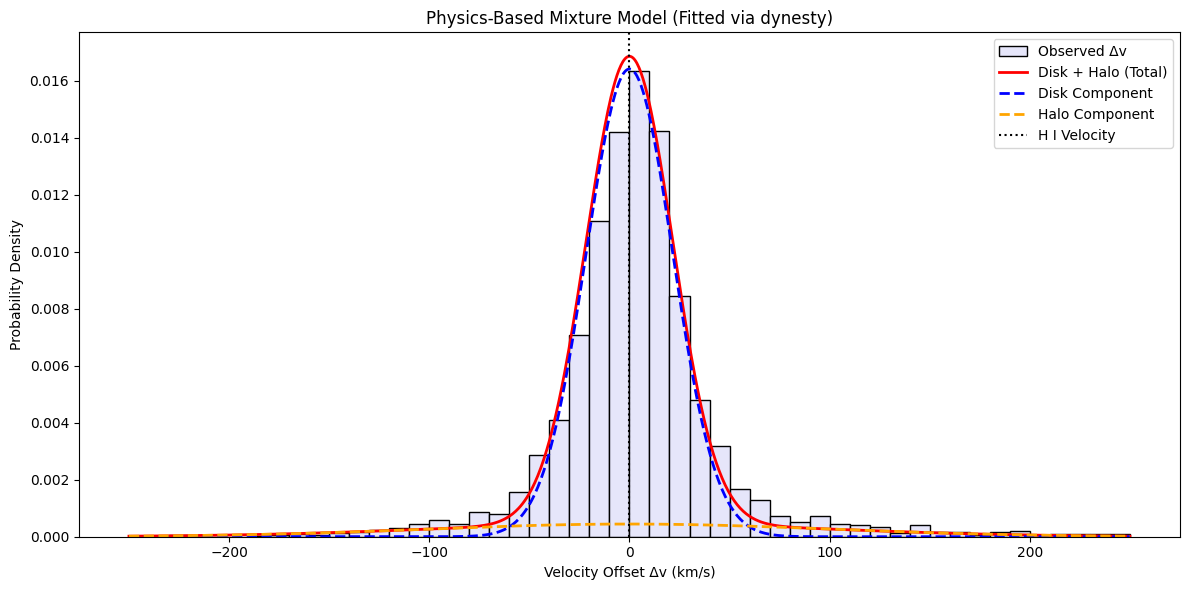

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from astropy.coordinates import SkyCoord
import astropy.units as u
import pandas as pd

# Step 1: Get observed and model velocities
# Filter to valid, numeric coordinates
ra = pd.to_numeric(df['RA_DEG'], errors='coerce')
dec = pd.to_numeric(df['DEC_DEG'], errors='coerce')
valid = ra.notnull() & dec.notnull()
df_valid = df.loc[valid].copy()
ra = ra[valid]
dec = dec[valid]
coords = SkyCoord(ra=ra.values * u.deg, dec=dec.values * u.deg)
model_vlos = compute_model_los_velocity(coords)
delta_v = df_valid['VCORR_STAT'].values - model_vlos  # Δv = v_star - v_model

# Step 2: Histogram setup
xarray = np.linspace(-250, 250, 1000)

# Step 3: genpdf_voffset (paste it in the notebook if not already defined)
# You can copy the full genpdf_voffset() function provided earlier

# Input prep for genpdf_voffset
extras = [0, 0, 1]   # dummy values for az, incl, R_proj_factor (not used in this version)
optflags = ['F', 'T']  # disk model OFF, halo model ON
modelvels = model_vlos
# parlist = [1.03, 22.3, 0.091, 0.00, 99.4]  # from dynesty fit or your best parlist

# Step 4: Generate model PDFs
disk_pdf, _, multi_disk_pdf, halo_pdf, total_pdf, f_halo = genpdf_voffset(xarray, parlist, extras, modelvels, optflags)

# Step 5: Plot
plt.figure(figsize=(12, 6))
plt.hist(delta_v, bins=50, range=(-250, 250), density=True, color='lavender', edgecolor='k', label='Observed Δv')

plt.plot(xarray, total_pdf, color='red', label='Disk + Halo (Total)', lw=2)
plt.plot(xarray, multi_disk_pdf, '--', color='blue', label='Disk Component', lw=2)
plt.plot(xarray, halo_pdf * f_halo, '--', color='orange', label='Halo Component', lw=2)

plt.axvline(0, color='black', linestyle=':', lw=1.5, label='H I Velocity')
plt.xlabel("Velocity Offset Δv (km/s)")
plt.ylabel("Probability Density")
plt.title("Physics-Based Mixture Model (Fitted via dynesty)")
plt.legend()
plt.tight_layout()
plt.show()